In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np

from pycbc import types
from pycbc import psd
from pycbc import noise

In [2]:
##Read in Grace-FO data 

#import data
fileobj = open('GRACE.csv', 'r')
readerobj = csv.reader(fileobj)


data = []
for row in readerobj:
    data.append(row)
    
fileobj.close()

#data

"Attached is the noise ASD data from GRACE-FO. It's in m/sqrt(Hz) so to get to strain you'll have to divide it by 220 km. The first column should be frequency in Hz and the second should be in ASD."

In [6]:
##Extract frequency and Strain data

data_array = np.array(data, dtype='d')
freqs = data_array[0:,0]
signal = data_array[0:,1]
strain = signal / 220.0e3 #converts between m/sqr(Hz) and 1/sqr(Hz)
freqs
np.size(strain)

3299

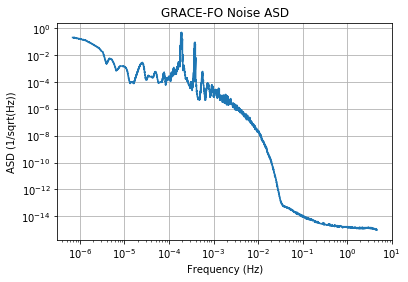

In [7]:
##Plot the data

plt.loglog(freqs, strain, label='gracefo')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (1/sqrt(Hz))')
plt.title('GRACE-FO Noise ASD')
plt.grid()
plt.show()

Tried Varying:
- dt - must remain 0.1 for 10 Hz
- N - can be very large but must be constant between noise curves
- Segment length for welch's - can vary but must be constant between noise curves
- filter order - can vary independently for noise curves
- beta parameter - can vary independently for noise curvs
- cutoff frequency - can vary independently but relies on df as a function of N (the larger N, the smaller df)


In [16]:
###Function for building a noise curve, taking it's psd. Returns the psd and sample frequencies

#modified in matched filter pipeline to output the filtered noise timeseries for combination
def lowpass_noise_psd(N, cutoff, order, beta, seg_num):
    #Parameters
    dt = 0.1 
    samples = N 
    T = dt * N
    f_s = 1.0 / dt
    df = 1.0 / T
    f_nyq = f_s / 2.0
    
    #noise signal
    np.random.seed(10000000)
    noise = np.random.uniform(-10, 10, size=samples)
    
    #convert to TimeSeries pycbc object
    noise_ts = types.timeseries.TimeSeries(noise, delta_t=dt)
    
    #filter it
    filtered = noise_ts.lowpass_fir(cutoff, order, beta=beta)
    
    #psd.welch
    seg_len = int(filtered.duration) // seg_num #higher number = more segments and increasing smoothing & decrease power
    seg_stride = seg_len // 2 #50% overlap
    noise_fs = psd.welch(filtered, seg_len=seg_len,
                         seg_stride=seg_stride)
    
    df = noise_fs.delta_f
    print('N:', N, 'dt:', dt,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)
    
    return noise_fs, noise_fs.sample_frequencies

def pycbc_welch(ts, segnum):
    seg_len = int(ts.duration) // segnum #higher number = more segments and increasing smoothing & decrease power
    seg_stride = seg_len // 2 #50% overlap
    noise_fs = psd.welch(ts, seg_len=seg_len,
                         seg_stride=seg_stride)
    return noise_fs

N: 80000 dt: 0.1 df: 0.008787346221441126 f_s: 10.0 f_nyq: 5.0
0.008787346221441126


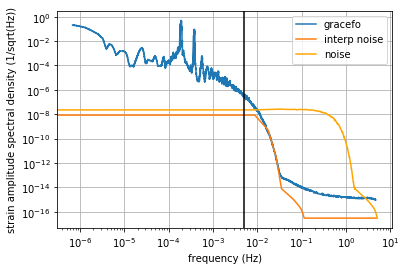

In [7]:
### the Hump asd portion saved parameters

#lowpass_noise_psd(N, cutoff, order, beta, seg_num)
N = 80000 
cutoff = 0.005
order = 150 
beta = 700.0 
seg_num = 7

##generate unshifted curve
fs1, freq1 = lowpass_noise_psd(N, cutoff, order, beta, seg_num)
fs1 = np.sqrt(fs1)*10e-9

#shift curve
freq_reduced = freq1 / 45
fs1_resampled = np.interp(freq1, freq_reduced, fs1)
fs1_fs = types.frequencyseries.FrequencySeries(fs1_resampled, fs1.delta_f)
freq1_fs = fs1_fs.sample_frequencies

print(fs1_fs.delta_f)

#generate timeseries of shifted curve
#noise1_ts = fs1_fs.to_timeseries(delta_t=0.1)

#compare with shifted curve
plt.loglog(freqs, strain, label='gracefo')
plt.loglog(fs1_fs.sample_frequencies, fs1_fs, label='interp noise')
plt.loglog(freq1, fs1, label='noise', color='orange')
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.axvline(cutoff, label='cutoff', color='k')
plt.grid()
plt.show()

Note to self - all changes, like scaling, to the noise timeseries (that I then hope to combine with another) must be made to the timeseries prior to taking the dft.

Then when taking the dft via welch's method, I must use the same parameters for seg_num and N to get the same df out.

Note to self - for frequency resolution of 10^-6, need a large sample size ~10 million


N: 400000 dt: 0.1 df: 0.0007538067239559777 f_s: 10.0 f_nyq: 5.0


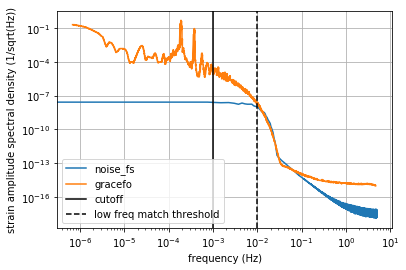

In [9]:
N = 400000 
cutoff = 0.001 #0.001 #0.001  
order = 1000 #610 #570 
beta = 18 #11.75 #11.0 
seg_num = 3

#noise signal
np.random.seed(138374923)
noise1 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise1_ts = types.timeseries.TimeSeries(noise1, delta_t=0.1)

#adjust amplitude
noise1_ts = noise1_ts * 10e-8

#filter it
filtered1 = noise1_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
seg_len = int(filtered1.duration) // seg_num #higher number = more segments and increasing smoothing & decrease power
seg_stride = seg_len // 2 #50% overlap
noise1_psd = psd.welch(filtered1, seg_len=seg_len,
                     seg_stride=seg_stride)

#conversion to asd
noise1_asd = np.sqrt(noise1_psd)

#some parameters
df = noise1_asd.delta_f
dt = 0.1 
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

#comparison
plt.loglog(noise1_asd.sample_frequencies, noise1_asd, label='noise_fs')
plt.loglog(freqs, strain, label='gracefo')

plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.axvline(cutoff, label='cutoff', color='k')
plt.axvline(0.01, label='low freq match threshold', linestyle='--', color='k')
plt.grid()
#plt.xlim(0.01, 0.1)
plt.legend()
plt.show()

N: 400000 dt: 0.1 df: 0.0007630093087135663 f_s: 10.0 f_nyq: 5.0


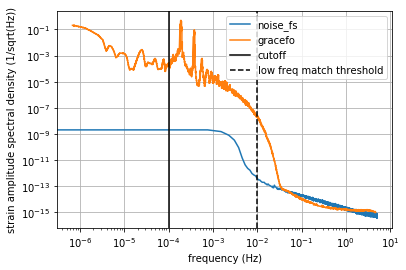

In [21]:
##Flat asd portion trial 

N = 400000 
cutoff = 0.0001 #0.001 #0.001   
order = 3400 #3000 #1000  
beta = 9.0 #8.0 #1  
seg_num = 3

#noise signal
np.random.seed(138374923)
noise2 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise2_ts = types.timeseries.TimeSeries(noise2, delta_t=0.1)

#adjust amplitude
noise2_ts = noise2_ts * 10e-9

#filter it
filtered2 = noise2_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
seg_len = int(filtered2.duration) // seg_num #higher number = more segments and increasing smoothing & decrease power
seg_stride = seg_len // 2 #50% overlap
noise2_psd = psd.welch(filtered2, seg_len=seg_len,
                     seg_stride=seg_stride)

#conversion to asd
noise2_asd = np.sqrt(noise2_psd)

#some parameters
df = noise2_asd.delta_f
dt = 0.1 
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

#comparison
plt.loglog(noise2_asd.sample_frequencies, noise2_asd, label='noise_fs')
plt.loglog(freqs, strain, label='gracefo')

plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.axvline(cutoff, label='cutoff', color='k')
plt.axvline(0.01, label='low freq match threshold', linestyle='--', color='k')
plt.grid()
plt.legend()
plt.show()

398000 393200
398000 398000


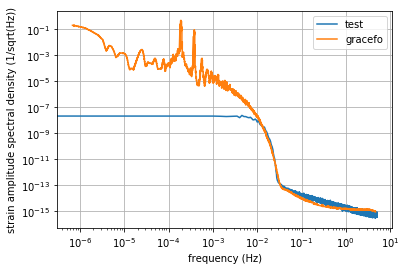

In [27]:
#check dimensions of timeseries
print(np.size(filtered1), np.size(filtered2))

#padd the smaller one
filtered2c = types.timeseries.TimeSeries(filtered2.copy(), 0.1)
filtered2c.append_zeros((np.size(filtered1)-np.size(filtered2)))
print(np.size(filtered1), np.size(filtered2c))

#Add the two
#combined_noise = filtered1 + filtered2
#combined_noise = filtered1.add_into(filtered2)
combined = np.array(filtered1) + np.array(filtered2c)
combined_ts = types.timeseries.TimeSeries(combined, filtered1.delta_t)

#welch's psd
combined_fs = pycbc_welch(combined_ts, 2)

#compare
plt.loglog(combined_fs.sample_frequencies, np.sqrt(combined_fs), label='test')
#plt.loglog(noise1_asd.sample_frequencies, noise1_asd, label='noise 1')
#plt.loglog(noise2_asd.sample_frequencies, noise2_asd, label='noise 2')
plt.loglog(freqs, strain, label='gracefo')

plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.grid()
plt.legend()

plt.savefig('grace_fo_model_curve_comparison.png')
plt.show()